# MAP Flatfield inference #


This notebook demonstrates inferring the MAP distribution of flat-field pixel values on a toy but realistic dataset. It is assumed that the PSF model is accurate (enough) for the purposes here.  Much of this notebook follows the 'ML Flatfield Inference' demo.


## The 'data' and PSF model ##

Import a toy dataset, where the 'detector' is a small 15x15 patch and 'stars' are generated for which approximately 50 are centered on a given pixel.

In [28]:
import sys
# simulator.py and psf_model.py live one directory up from here.
sys.path.append('../')

from simulator import FakeProblem
from psf_model import PSFModel

seed = 12353

# Use Jay Anderson's WFC3 F160W PSF model.
psfmodel = PSFModel('../../psfs/anderson.fits')

# Made up numbers which are close to what RF has seen in the actual data.
ds = 15 # 15 x 15 detector.
ps = 5 # 5 x 5 patches for the data.
flr, gn = 0.05, 0.01
problem = FakeProblem(psfmodel, flat_rng=0.1, flux_range=(50, 500),
                      bkg_range=(0, 1.),
                      N_mean=50, noise_parms=(flr, gn), detector_side=ds,
                      seed=seed)


Here is what a data patch looks like, along with a noiseless version of it:

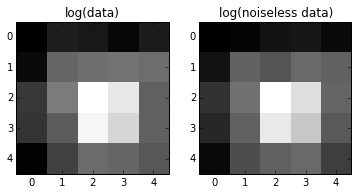

In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl

patch = problem.data[0].reshape(ps, ps)
psf = problem.psfs[0].reshape(ps, ps) * problem.fluxes[0] + \
    problem.bkgs[0]

pl.gray()
pl.subplot(121)
pl.imshow(np.log(patch), interpolation='nearest')
pl.title('log(data)')
pl.subplot(122)
pl.imshow(np.log(psf), interpolation='nearest')
pl.title('log(noiseless data)')
pl.show()


Here are the true flatfield values:

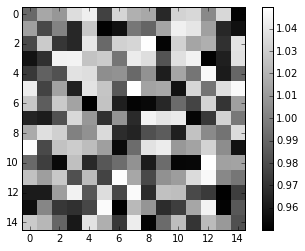

In [30]:
pl.imshow(problem.flat_field, interpolation='nearest')
pl.colorbar()
pl.show()

Finally, here are the number of patches whos centroids touch a pixel above:

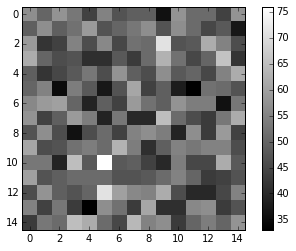

Total number of patches: 11360


In [31]:
pl.imshow(problem.coverages, interpolation='nearest')
pl.colorbar()
pl.show()
print 'Total number of patches:', problem.coverages.sum()

## Model, NLL, and gradients ##

We will be evaluating the likelihood of the data given flatfield and individual model parameters, so lets define those.  First, the model for the data is a set of flat field values (one per pixel) and a set of PSFs, fluxes, and backgrounds for the patches.  The model for an individual patch is:

$$m_i = f_i * (A_i * P_i + B_i)$$

where $m_i$ is the model for the $i$th patch, $A_i$ is the amplitude or flux that is received via the Point Spread Function $P_i$, and $B_i$ is a scalar model for the background flux.  Note $f_i$ is the flatfield for that particular patch, looked up from the values defined over the detector.

Ok, with the model in place we need the negative log likelihood:

In [47]:
# mapper function 
from utils import FlatMapper

def nll(parms, data, psfs, pxl_locs, floor, gain):
    """
    Return the negative log likelihood of the data given a flat field 
    (first part of parms vector), flux values for the models (next N 
    values of parms vector), and constant background values (final N
    values).
    """
    N, D = psfs.shape
    M = ds ** 2 # ds is out of namespace.
    flat = parms[:M].reshape(ds, ds) # current flat field model

    # this is a lookup function which defines the relationship
    # between local and global flats.
    mapper = FlatMapper(flat, 5, pxl_locs) 
    flat_patches = mapper.get_1D_flat_patches()

    fluxes = parms[M:(M + N)]
    bkgs = parms[(M + N):(M + 2 * N)]

    # model for the incoming flux
    input_m = fluxes[:, None] * psfs + bkgs[:, None]

    # model for the data (sensitivity of flat included.)
    m = flat_patches * input_m

    # the model for the variance of the noise
    v = floor + gain * m

    # ignores a log(2pi)
    nll = (data - m) ** 2. / v + np.log(v)
    return 0.5 * np.sum(nll)

For this demo, we are going to want to work with the posterior and for that we need priors.  For now, we are just going to specify a prior on the flatfield:
$$\sum_{jk} (F_{jk} - 1)^2$$
This is a vary soft prior (Normal with variance 1), but should be enough to break the degeneracy between the flat mean and the fluxes.

In [97]:
def neg_log_post(parms, data, psfs, pxl_locs, floor, gain):
    """
    Return the negative log posterior probability.
    """
    nll_value = nll(parms, data, psfs, pxl_locs, floor, gain)

    N, D = psfs.shape
    M = ds ** 2 # ds is out of namespace.
    flat = parms[:M].reshape(ds, ds) # current flat field model
    
    # gaussian prior on flat, ignores a log(2pi)
    neg_log_flat_prior = 1.e-1 * (np.sum(flat) - 1) ** 2. 
    return nll_value + neg_log_flat_prior

The model is simple and it is easy to write down the gradient of the parameters.  This will be important to find optima and (perhaps) sample.


In [96]:
def grad_model(flat_patches, fluxes, bkgs, data, psfs, floor, gain):
    """
    Gradient of the model with respect to the NLL.
    """
    input_m = fluxes[:, None] * psfs + bkgs[:, None]
    m = flat_patches * input_m
    iv = 1. / (floor + gain * m)
    dmm = data - m
    dmm2 = dmm ** 2.
    grad = -2. * dmm * iv
    grad -= gn * dmm2 * iv ** 2
    grad += gn * iv
    return 0.5 * grad

def grad_flat_nll(input_m, grad_m, row_ind, col_ind):
    """
    Gradient of the flat model in the NLL term.
    """
    # NLL term
    grad = np.zeros((ds, ds))
    for i in range(input_m.shape[0]):
        g = (input_m[i] * grad_m[i]).reshape(5, 5)
        grad[row_ind[i], col_ind[i]] += g    
    return grad.ravel()

def grad_fluxes(flat_patches, psfs, grad_m):
    """
    Gradient of the fluxes.
    """
    return np.sum(flat_patches * psfs * grad_m, axis=1)

def grad_bkgs(flat_patches, grad_m):
    """
    Gradient of the backgrounds
    """
    return np.sum(flat_patches * grad_m, axis=1)

def grads_indiv(parms, data, psfs, pxl_locs, floor, gain):
    """
    Return the gradients for flux and bkg params.
    """
    N, D = psfs.shape
    M = ds ** 2
    flat = parms[:M].reshape(ds, ds)
    mapper = FlatMapper(flat, 5, pxl_locs)
    flat_patches = mapper.get_1D_flat_patches()
    fluxes = parms[M:(M + N)]
    bkgs = parms[(M + N):(M + 2 * N)]
    input_m = fluxes[:, None] * psfs + bkgs[:, None]
    grad_m = grad_model(flat_patches, fluxes, bkgs, data,
                        psfs, floor, gain)
    fxg = grad_fluxes(flat_patches, psfs, grad_m)
    bkg = grad_bkgs(flat_patches, grad_m)
    return np.append(fxg, bkg)

def grads_all(parms, data, psfs, pxl_locs, floor, gain):
    """
    Return the gradients for all parameters (flat, fluxes, bkgs).
    """
    N, D = psfs.shape
    M = ds ** 2
    flat = parms[:M].reshape(ds, ds)
    mapper = FlatMapper(flat, 5, pxl_locs)
    flat_patches = mapper.get_1D_flat_patches()
    fluxes = parms[M:(M + N)]
    bkgs = parms[(M + N):(M + 2 * N)]
    input_m = fluxes[:, None] * psfs + bkgs[:, None]
    grad_m = grad_model(flat_patches, fluxes, bkgs, data,
                        psfs, floor, gain)
    # NLL term
    flg = grad_flat_nll(input_m, grad_m, mapper.rowinds, mapper.colinds)

    # prior term
    flg += 1.e-1 * 2. * (flat.ravel() - 1.)
    
    fxg = grad_fluxes(flat_patches, psfs, grad_m)
    bkg = grad_bkgs(flat_patches, grad_m)
    return np.append(np.append(flg, fxg), bkg)


Lets check these gradients numerically.

In [86]:
h = 1.e-6
N, D = problem.psfs.shape
M = ds ** 2
flat0 = np.ones((ds, ds))
parms = np.append(np.append(flat0, problem.fluxes),
                  problem.bkgs)
g = grads_all(parms, problem.data, problem.psfs, pxl_locs, flr, gn)

# subsample
Ng = 15
ind = np.append(np.append(np.random.permutation(M)[:Ng],
                          (np.random.permutation(N) + M)[:Ng]),
               (np.random.permutation(N) + M + N)[:Ng])


for i in ind:
    if i < M:
        ms = 'Flat grad'
    elif i > M + N:
        ms = 'Bkg  grad'
    else:
        ms = 'Flux grad'

    f = parms.copy()
    f[i] += h
    fnll = nll(f, problem.data, problem.psfs, pxl_locs, flr, gn)
    f[i] -= 2 * h
    bnll = nll(f, problem.data, problem.psfs, pxl_locs, flr, gn)
    n = (fnll - bnll) / 2. / h
    print '%s, %5d: Anl %0.2e Num %0.2e' % (ms, i, g[i], n)
    

Flat grad,    36: Anl -1.12e+04 Num -1.12e+04
Flat grad,    77: Anl -4.44e+03 Num -4.44e+03
Flat grad,    75: Anl -6.38e+02 Num -6.38e+02
Flat grad,   185: Anl -1.85e+04 Num -1.85e+04
Flat grad,   204: Anl 3.43e+03 Num 3.43e+03
Flat grad,   157: Anl -3.31e+03 Num -3.31e+03
Flat grad,   155: Anl 1.00e+04 Num 1.00e+04
Flat grad,    30: Anl 2.25e+02 Num 2.25e+02
Flat grad,     2: Anl 4.81e+01 Num 4.81e+01
Flat grad,   218: Anl 1.07e+03 Num 1.07e+03
Flat grad,    24: Anl -1.97e+03 Num -1.97e+03
Flat grad,    40: Anl -1.26e+04 Num -1.26e+04
Flat grad,    72: Anl -1.39e+04 Num -1.39e+04
Flat grad,    27: Anl -6.24e+02 Num -6.24e+02
Flat grad,    68: Anl -3.02e+03 Num -3.02e+03
Flux grad,  2608: Anl 1.53e+00 Num 1.53e+00
Flux grad,  6158: Anl -2.31e+00 Num -2.31e+00
Flux grad,   371: Anl -5.60e-01 Num -5.60e-01
Flux grad,  3458: Anl -2.24e+00 Num -2.24e+00
Flux grad,  1576: Anl -3.32e-01 Num -3.32e-01
Flux grad,  1643: Anl 4.19e-01 Num 4.19e-01
Flux grad,  6251: Anl 7.00e-01 Num 7.00e-01
Flux

## Timing and MAP ##

Below are some of the times it takes to perform relavent calculations to the problem.

First, the time it takes to evaluate the negative log likelihood.

In [36]:
flat0 = np.ones((ds, ds))
parms = np.append(np.append(flat0, problem.fluxes),
                  problem.bkgs)
pxl_locs = (problem.row_centers, problem.col_centers)
print 'NLL eval time:'
%timeit nll(parms, problem.data, problem.psfs, pxl_locs, flr, gn)


NLL eval time:
100 loops, best of 3: 6.34 ms per loop


Ok, now the various gradients:

In [37]:
print 'Gradient eval time for just fluxes and bkgs:'
%timeit grads_indiv(parms, problem.data, problem.psfs, pxl_locs, flr, gn)

print 'Gradient eval time for all parms:'
%timeit grads_all(parms, problem.data, problem.psfs, pxl_locs, flr, gn)


Gradient eval time for just fluxes and bkgs:
100 loops, best of 3: 9.46 ms per loop
Gradient eval time for all parms:
10 loops, best of 3: 48.1 ms per loop


Lets see how long it takes to optimize the flat, flux, and background parameters for the patches.

In [98]:
# realistic starting values
f0s = problem.data.sum(1)
b0s = np.zeros(f0s.size)
parms = np.append(np.append(flat0, f0s), b0s)

from scipy.optimize import fmin_l_bfgs_b as bfgs
from time import time
t0 = time()
res = bfgs(neg_log_post, parms, fprime=grads_all,
           args=(problem.data, problem.psfs, pxl_locs, flr, gn))
print 'Optimized in %0.2f sec' % (time() - t0)

Optimized in 74.36 sec


## Results ##

Lets see how we did.

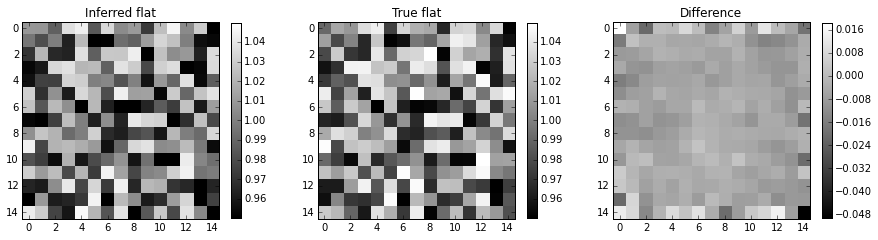

In [104]:
flat = res[0][:ds ** 2].reshape(ds, ds)
#flat /= np.median(flat) # in general this seems to be a good thing to do.
tff = problem.flat_field

pl.figure(figsize=(15,5))
pl.subplot(131)
pl.imshow(flat, interpolation='nearest', vmin=tff.min(), vmax=tff.max())
pl.title('Inferred flat')
pl.colorbar(shrink=0.7)
pl.subplot(132)
pl.imshow(tff, interpolation='nearest')
pl.title('True flat')
pl.colorbar(shrink=0.7)
pl.subplot(133)
diff = flat - problem.flat_field
pl.imshow(diff, interpolation='nearest')
pl.title('Difference')
pl.colorbar(shrink=0.7)
pl.show()



By eye, it seems we have done very well!  Comparing the pattern of the inferred flat (initialized as all ones) to the true flat, there is remarkable agreement.  Notice that in the difference image the results are markedly worse on the 2 pixel border.  This is because we do not allow for patial patches to enter the fit (assuring stellarity is hard for partial patches!).

Statistics of the inner 13x13 region:

In [103]:
err = np.sqrt(diff[2:-2, 2:-2] ** 2)
print 'Root Median Sq. Err', np.median(err)
print 'Root Mean Sq. Err', np.mean(err)
print 'STD in Root Sq. Err', np.std(err)

Root Median Sq. Err 0.00480014741943
Root Mean Sq. Err 0.00500251967643
STD in Root Sq. Err 0.00237912638226


This is pretty good - initially there were errors of about 5% in the flat field, now they are about 0.6%!